In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

DSCI 100 Project Final Report 

Introduction:

Understanding player behaviour is essential for improving game design to retain long-term users and engagement. In this project, we analyzed data from Plaicraft, a Minecraft server operated by a research group at UBC to help them gain insight into their population of users. We explored the question: Can variables such as a player's age and experience level be used to predict the total hours played on the server? This will allow us to assess the extent of the association between these variables with player engagement. If strong correlations were found, it could provide information on future contribution given past participation and identify the key factors influencing player activity. Two datasets were provided to use for our analyses: the Players and the Sessions dataset, which gave information about the players and their gameplay activity. In the Players dataset, there are 197 observations about the demographic:
experience (categorical skill level like "Pro", "Amateur", etc.)
subscribe (logical variable indicating if they are subscribed)
hashedEmail (unique anonymized ID)
played_hours (numerical)
name (categorical)
gender (categorical)
age (numerical)
In the Sessions dataset, there are 1536 observations on the individual gameplay sessions:
hashedEmail (anonymized ID linked to the Players dataset)
start_time (date and time player started)
end_time (date and time player stopped)
original_start_time (unix timestamp)
original_end_time (unix timestamp)
However, the Sessions dataset was not used due to limitations that made it less suitable for our purposes. The original start time and end time were often identical for sessions under two hours, making it difficult to calculate the durations accurately. The data was also split across multiple records for each player, requiring preprocessing to combine the durations and then match them to the Players dataset. Therefore, using only the Players dataset, which already provided the total hours played, reduced the need for additional wrangling. To build our predictive model, we applied two different regression analyses: K-Nearest Neighbors (KNN) and linear regression and compared which model yields a lower RMSE. This helps us evaluate which technique better captures the relationship between age and experience level with hours played and how effective these variables are in modeling player behaviour.

The method used to perform our analysis was to conduct both K-nn and linear regression using age and experience level to see if they can independently predict the number of hours played. The players.csv and sessions.csv datasets were first loaded into R

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players_data <- read_csv(players_url)

head(players_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [3]:
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

sessions_data <- read_csv(sessions_url)

head(sessions_data)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


Then for the players.csv dataset the columns that had data were selected, players_data, experience, subscribe, hashedEmail, played_hours, gender, and age. The empty columns were removed.

In [4]:
players_select <- players_data |>
    select(experience, subscribe, hashedEmail, played_hours, gender, age)
head(players_select)

experience,subscribe,hashedEmail,played_hours,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Female,17


For the sessions.csv dataset the columns of start_time and end_time included both dates and times in the data. It was decided that this data should be split into two separate columns, one for the start_date, one for the start_time. The same was done for end_time. 

In [5]:
sessions_data_split <- sessions_data |>
   separate(start_time, into = c("start_date", "start_time"), sep = " ") |>
   separate(end_time, into = c("end_date", "end_time"), sep = " ")
head(sessions_data_split)

hashedEmail,start_date,start_time,end_date,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,18:12,30/06/2024,18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,23:33,17/06/2024,23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,17:34,25/07/2024,17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024,03:22,25/07/2024,03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024,16:01,25/05/2024,16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024,15:08,23/06/2024,17:10,1.71916e+12,1.71916e+12


Next the two datasets were combined into a single dataset and turned into a tidy format.

In [6]:
combined_data <- players_select |>
	left_join(sessions_data_split, by = "hashedEmail")

head(combined_data) 

tidy_plaicraft <- combined_data |>
   select(start_time:end_time, experience:age)

head(tidy_plaicraft)

experience,subscribe,hashedEmail,played_hours,gender,age,start_date,start_time,end_date,end_time,original_start_time,original_end_time
<chr>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9,08/08/2024,00:21,08/08/2024,01:35,1.72308e+12,1.72308e+12
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9,09/09/2024,22:30,09/09/2024,22:37,1.72592e+12,1.72592e+12
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9,08/08/2024,02:41,08/08/2024,03:25,1.72308e+12,1.72309e+12
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9,10/09/2024,15:07,10/09/2024,15:29,1.72598e+12,1.72598e+12
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9,05/05/2024,22:21,05/05/2024,23:17,1.71495e+12,1.71495e+12
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9,06/04/2024,22:24,06/04/2024,23:33,1.71244e+12,1.71245e+12


start_time,end_date,end_time,experience,subscribe,hashedEmail,played_hours,gender,age
<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>,<dbl>
00:21,08/08/2024,01:35,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
22:30,09/09/2024,22:37,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
02:41,08/08/2024,03:25,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
15:07,10/09/2024,15:29,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
22:21,05/05/2024,23:17,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
22:24,06/04/2024,23:33,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9


Some initial basic graphs/charts were created just for simple visualization of the different selected variables against time. These included an age scatter plot which showed player age against hours played, a gender bar graph which displayed the distribution hours played by gender, and an experience bar graph which displayed the distribution of hours played by player experience. 

gender,count
<chr>,<int>
Female,395
Male,1056
Non-binary,113
Prefer not to say,24
Two-Spirited,6


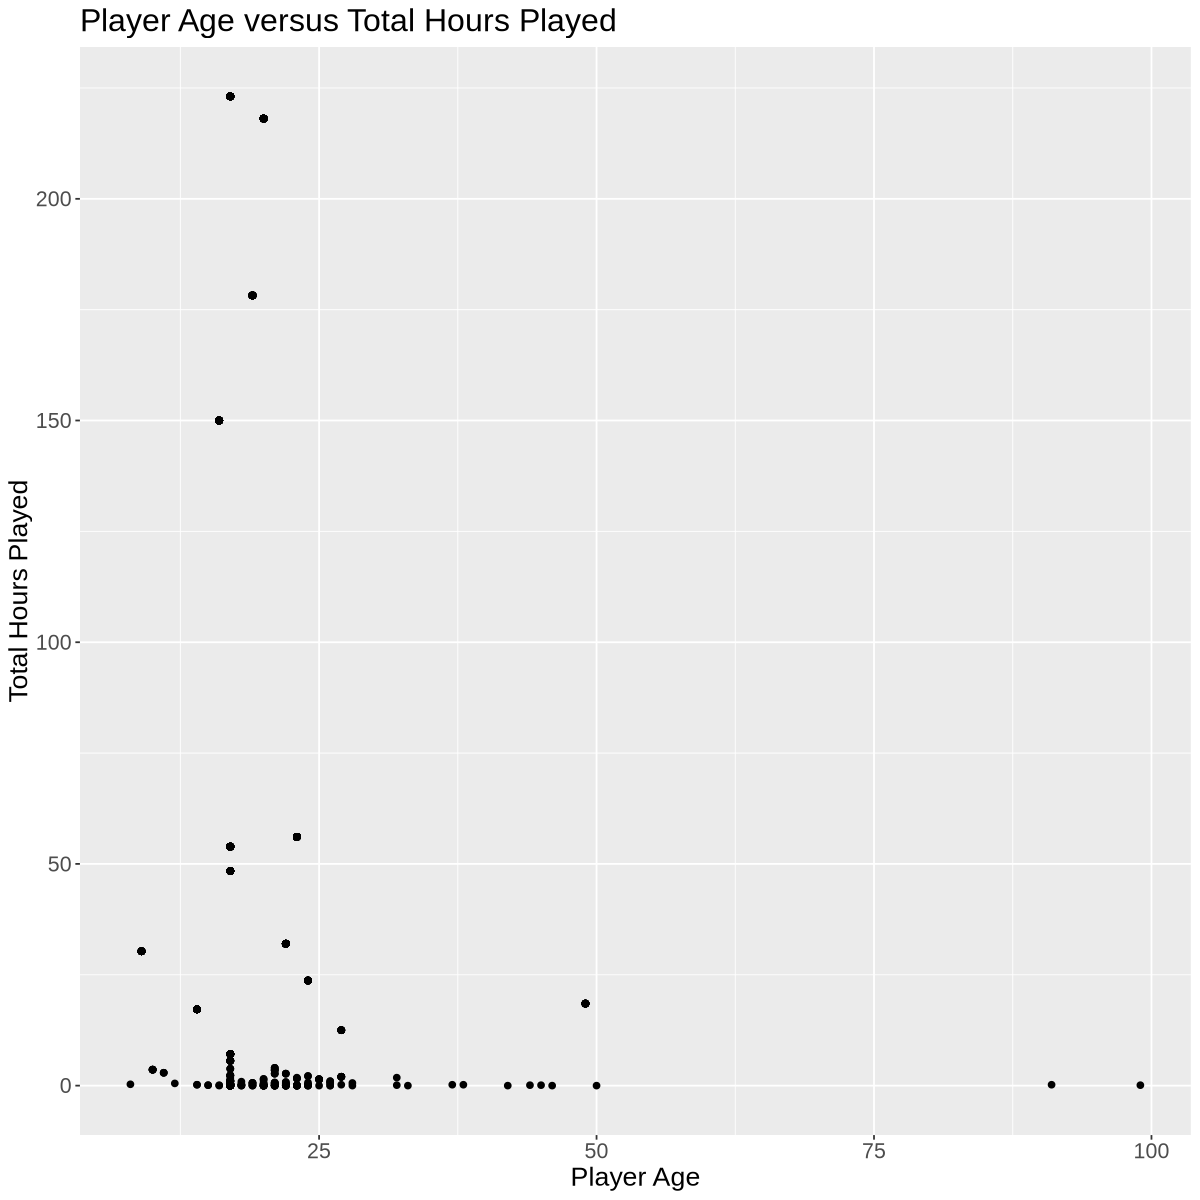

experience,count
<chr>,<int>
Amateur,841
Beginner,119
Pro,42
Regular,532
Veteran,72


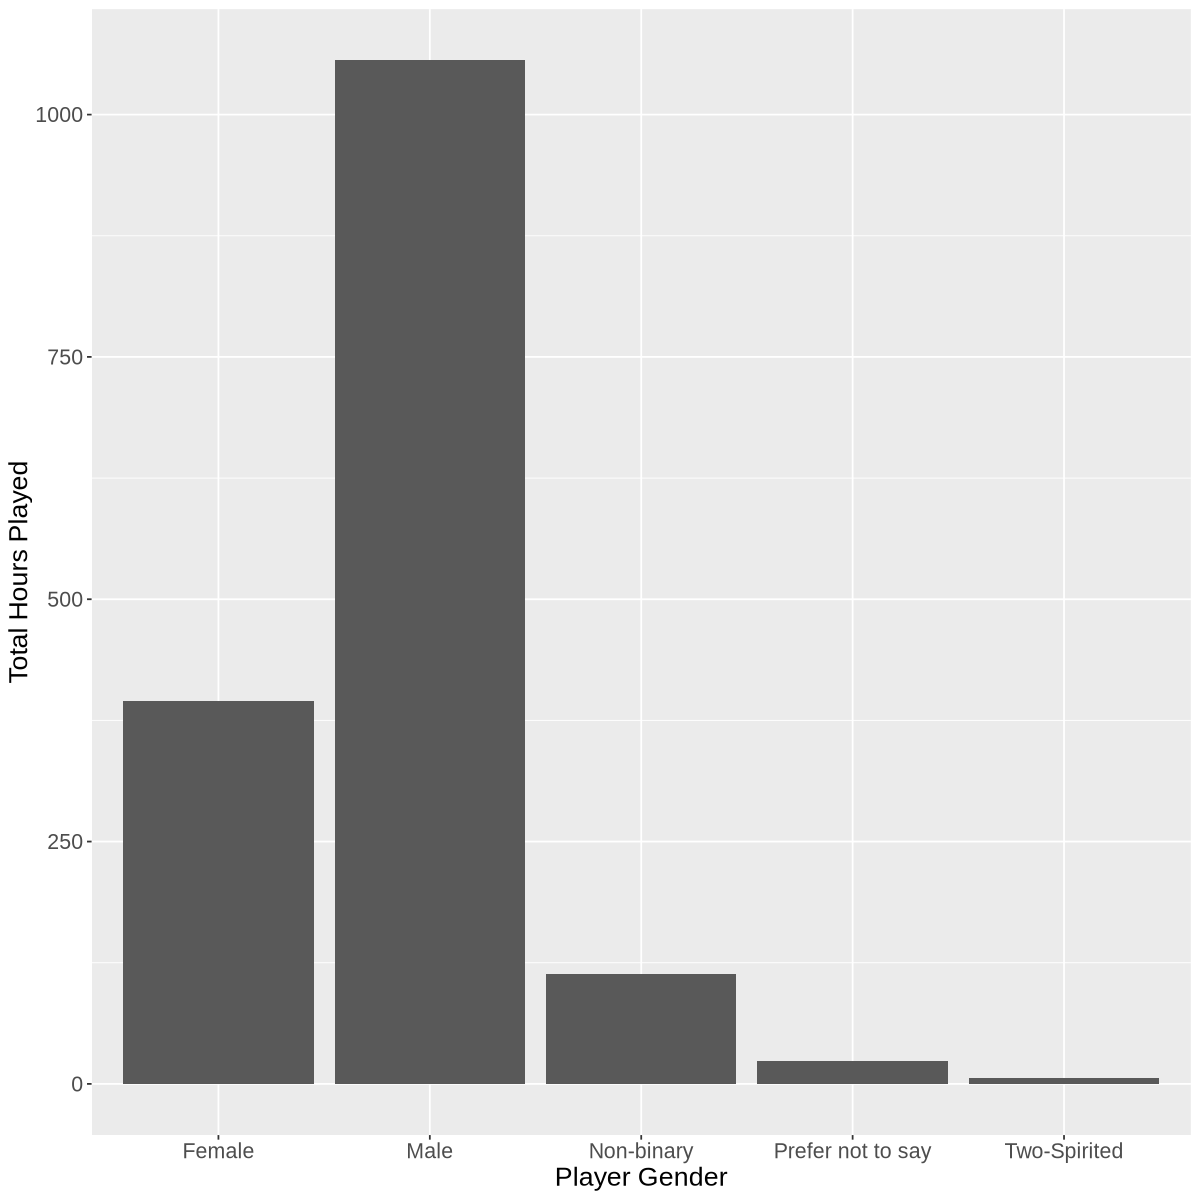

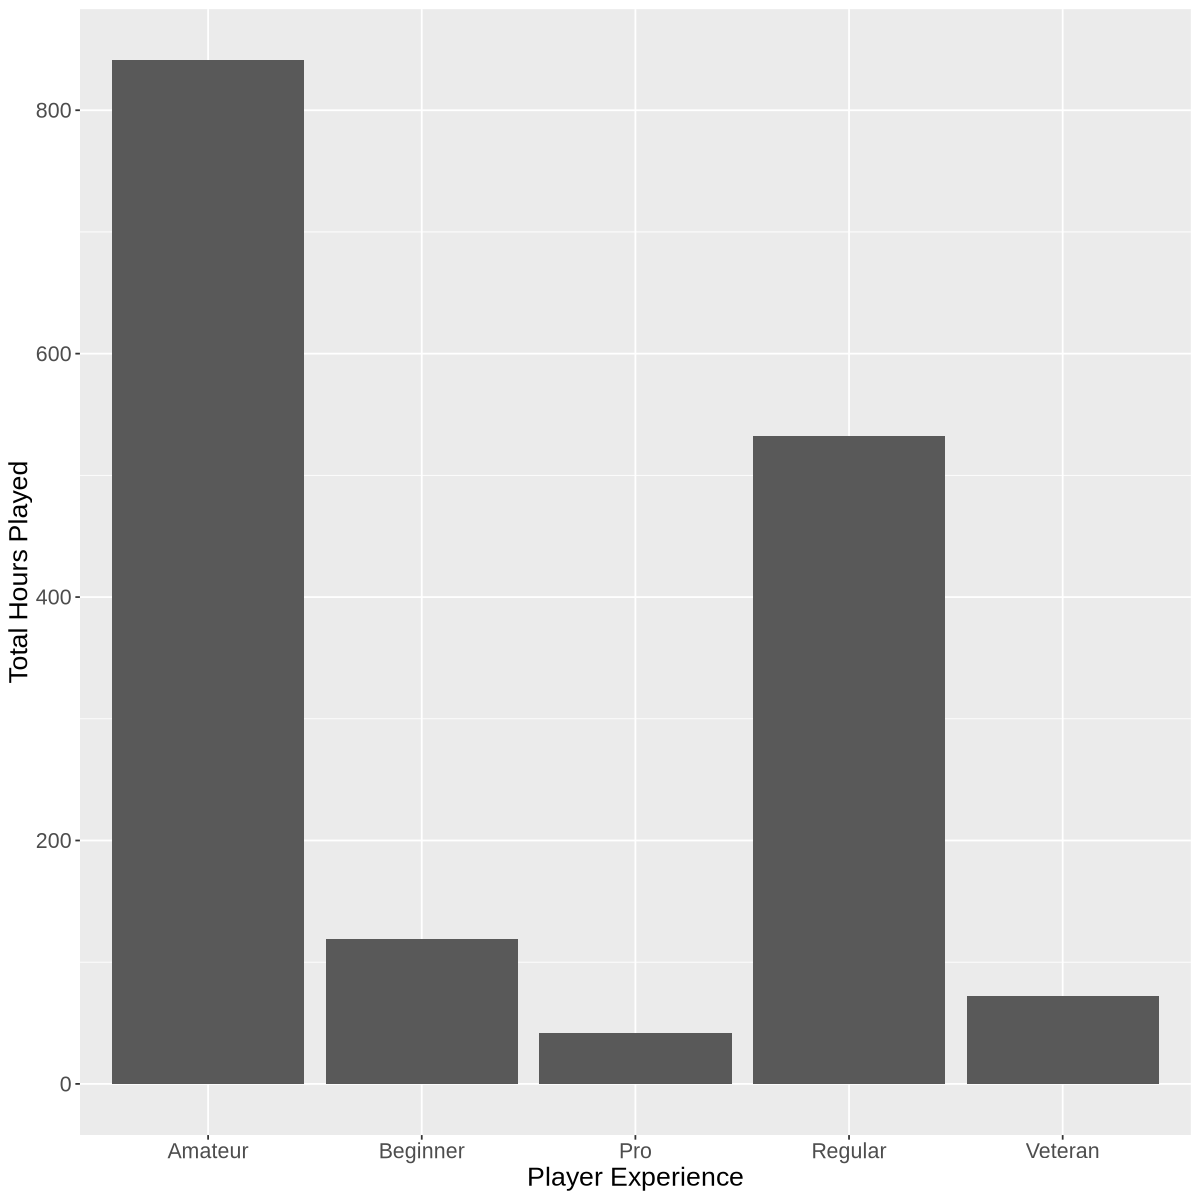

In [7]:
options(repr.plot.height = 10, repr.plot.width = 10)
age_plot <- tidy_plaicraft |>
   ggplot(aes(x = age, y = played_hours)) +
   geom_point() +
   labs(x = "Player Age",
    	y = "Total Hours Played",
    	title = "Player Age versus Total Hours Played") +
   theme(text = element_text(size = 16))

age_plot

gender_set <- tidy_plaicraft |>
   filter(gender %in% c("Male", "Female", "Two-Spirited", "Prefer not to say", "Non-binary")) |>
   group_by(gender) |>
   summarize(count = n())

gender_set

options(repr.plot.height = 10, repr.plot.width = 10)
gender_bar <- ggplot(gender_set, aes(x = gender, y = count)) +
  geom_bar(stat = "identity") +
  xlab("Player Gender") +
  ylab("Total Hours Played")+
 theme(text = element_text(size = 16))

gender_bar

experience_set <- tidy_plaicraft |>
   filter(experience %in% c("Beginner", "Pro", "Amateur", "Regular", "Veteran")) |>
   group_by(experience) |>
   summarize(count = n())

experience_set

options(repr.plot.height = 10, repr.plot.width = 10)
exp_bar <- ggplot(experience_set, aes(x = experience, y = count)) +
  geom_bar(stat = "identity") +
  xlab("Player Experience") +
  ylab("Total Hours Played")+
 theme(text = element_text(size = 16))

exp_bar

We then tested the two different types of regression to determine if it is possible to predict the total hours played/total session frequency based on explanatory variables (age, gender, experience, etc). Thus, using regression modelling can help determine whether there is a relationship between the proposed predictors and our target responses. To select the best regression model we determined the RMSE & RMPSE and chose the model with the lowest error. We conducted these regressions with a 75% training and 25% test dataset split. Furthermore, to increase reliability conducted cross-validation to check the model for overfitting and performance using a 5 fold function. 

For K-nn regression of age and played hours, the age data and played hours columns were selected from our players.csv dataset and filtered for outliers over the age of 49 and less than the age of 10 as we believed these to be dishonest self surveyed answers. The data was then split using a 0.75 ratio into a training and testing set. Next, the model function was created setting the engine and mode to knn regression, neighbors was also set to tune() in order to later select the optimal amount of neighbors to reduce error. Following this, the recipe function was created setting played_hours to be predicted by age, and using the step functions to scale all the predictors. To cross-validate we also used the vfold function with a 5 fold to check for the model’s performance and we added our recipe and model into our age workflow function to complete the preparation. 

In [8]:
age_data <- players_data|>
	select(age, played_hours)|>
	filter(!(age >49))|>
	filter(!(age <10))
      	 
head(age_data)

set.seed(411)

age_split <- initial_split(age_data, prop=0.75, strata = played_hours)
age_training <- training(age_split)
age_testing <- testing(age_split)

set.seed(411)

age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
	set_engine("kknn")|>
	set_mode("regression")

age_recipe <- recipe(played_hours ~ age, data = age_training)|>
	step_scale(all_predictors()) |>
	step_center(all_predictors())

age_vfold <- vfold_cv(age_training, v=5, strata = played_hours)

age_workflow <- workflow()|>
	add_recipe(age_recipe)|>
	add_model(age_spec)

age_workflow

age,played_hours
<dbl>,<dbl>
17,3.8
17,0.0
21,0.7
21,0.1
17,0.0
19,0.0


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next to test all the potential neighbors we initiated the process using the gradvals function, then applied our age workflow to be tuned using our vfold function and gridval function. We then collected our RMPSE metric, filtered it for the lowest neighbor value, and pulled it out to set it as our kmin. The minimum RMPSE value occurs at K = 111 which is our kmin and that was selected for our knn model to fit onto our data. The preparation steps were then repeated again, now using the kmin neighbor value instead of tune(). As an additional step we created a small table of the .metric, .estimator, and .estimate of the lowest RMSE value that was pulled out. 

In [9]:
set.seed(411)

gridvals <- tibble(neighbors = seq(1, 113, by = 2))

age_results <- age_workflow|>
	tune_grid(resamples = age_vfold, grid = gridvals)|>
	collect_metrics()|>
	filter(.metric=="rmse")
 
head(age_results)

age_min <- age_results|>
	filter(mean==min(mean))

age_min

kmin <- age_min|>
	pull(neighbors)

age_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

age_best_fit <- workflow() |>
  add_recipe(age_recipe) |>
  add_model(age_best_spec) |>
  fit(data = age_training)

age_rmse <- age_best_fit |>
  predict(age_testing) |>
  bind_cols(age_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

age_rmse

→ A | warning: 113 samples were requested but there were 113 rows in the data. 108 will be used.

There were issues with some computations   A: x1

→ B | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1
→ C | warning: 113 samples were requested but there were 114 rows in the data. 109 will be used.

There were issues with some computations   A: x1
There were issues with some computations   A: x2   B: x1   C: x2

There were issues with some computations   A: x2   B: x1   C: x3





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,30.06254,5,7.258921,Preprocessor1_Model01
3,rmse,standard,27.57467,5,4.953699,Preprocessor1_Model02
5,rmse,standard,24.12465,5,6.035328,Preprocessor1_Model03
7,rmse,standard,23.02854,5,6.599479,Preprocessor1_Model04
9,rmse,standard,22.34876,5,6.819957,Preprocessor1_Model05
11,rmse,standard,21.99935,5,6.934589,Preprocessor1_Model06


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
111,rmse,standard,21.09033,5,6.908604,Preprocessor1_Model56


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,37.03135


With our best k neighbors value we then proceeded to create a scatter plot of the relationship between player age and played hours to determine the strength of the predictor of age to predict hours played.

.pred,age,played_hours
<dbl>,<dbl>,<dbl>
5.873874,17,0.0
5.427928,21,0.1
5.873874,17,0.0
5.873874,17,0.1
5.431532,22,0.0
5.873874,17,0.0


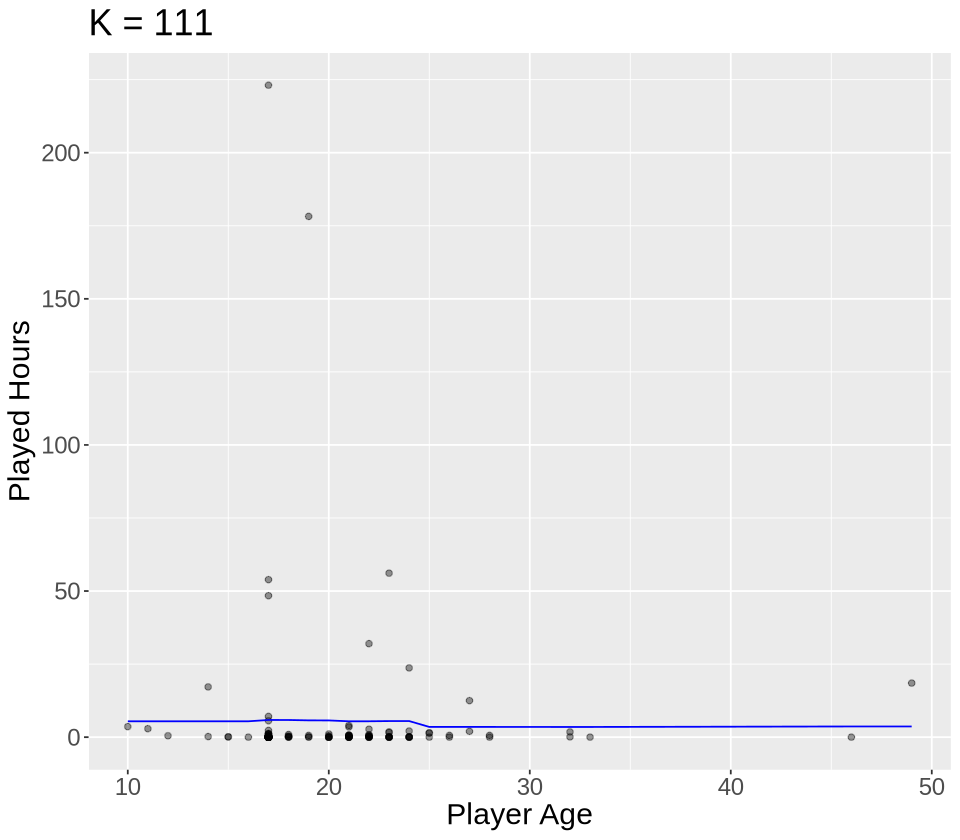

In [10]:
set.seed(411)
options(repr.plot.width=8, repr.plot.height=7)

age_prediction_grid <- tibble(age = seq(from = players_data |> select(age) |> min(),
                                    	to = players_data|> select(age) |> max(), by = 10))

age_preds <- age_best_fit|>
predict(age_training)|>
bind_cols(age_training)

head(age_preds)

age_plot <- age_preds|>
	ggplot(aes(x= age, y=played_hours))+
	geom_point(alpha = 0.4)+
	geom_line(data = age_preds, mapping =aes(x=age,y=.pred),
          	color="blue")+
	labs(x="Player Age", y= "Played Hours", title= "Player Age vs Played Hours")+
	ggtitle(paste0("K = ", kmin))+
	theme(text = element_text(size = 18))

age_plot

From the graph we determined that there was not a strong relationship between a player’s age and the number of hours they played. Secondly, based on our graph it seems the model does fit the model but it also seems to be very flat, indicating that the model may not be influenced enough by the training data. 


In the following code, we use Linear Regression on the data with age of the player as the explanatory variable to predict a player’s total hours played in the server. Before starting the data analysis, we do not filter any of the data points. We split the dataset into 25% testing and 75% training.

played_hours,age
<dbl>,<dbl>
30.3,9
3.8,17
0.7,21
0.1,21
0.1,17
1.6,23


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
     9.1428      -0.1183  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,57.564392485
rsq,standard,0.005743024
mae,standard,24.531250051


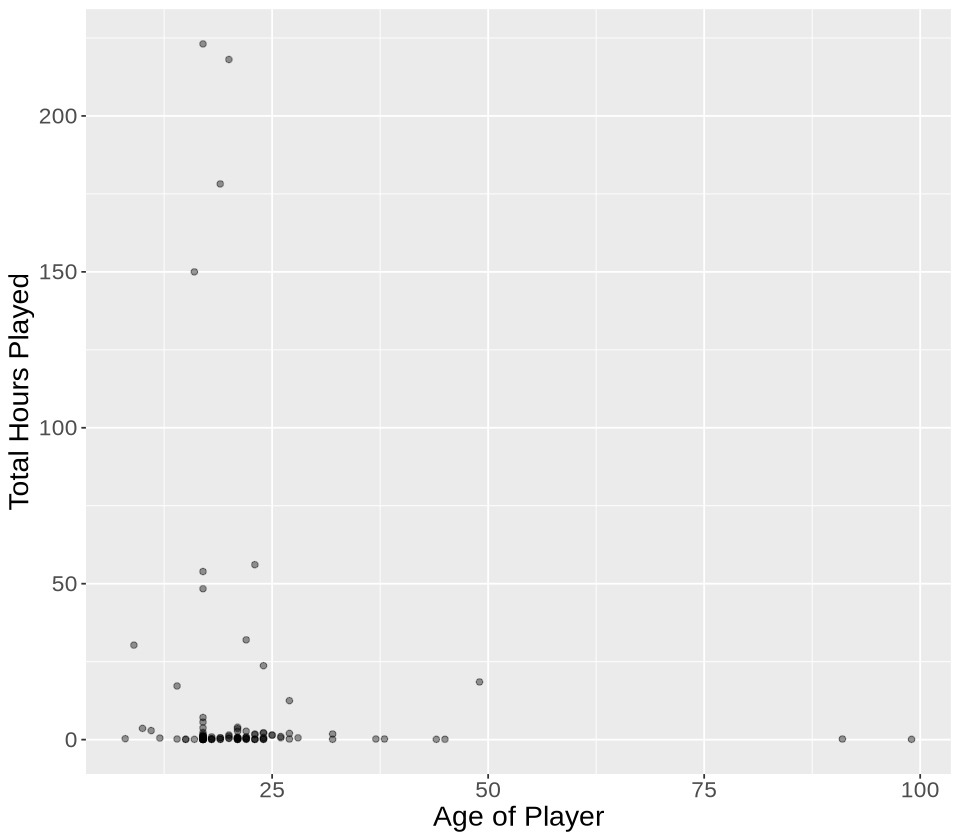

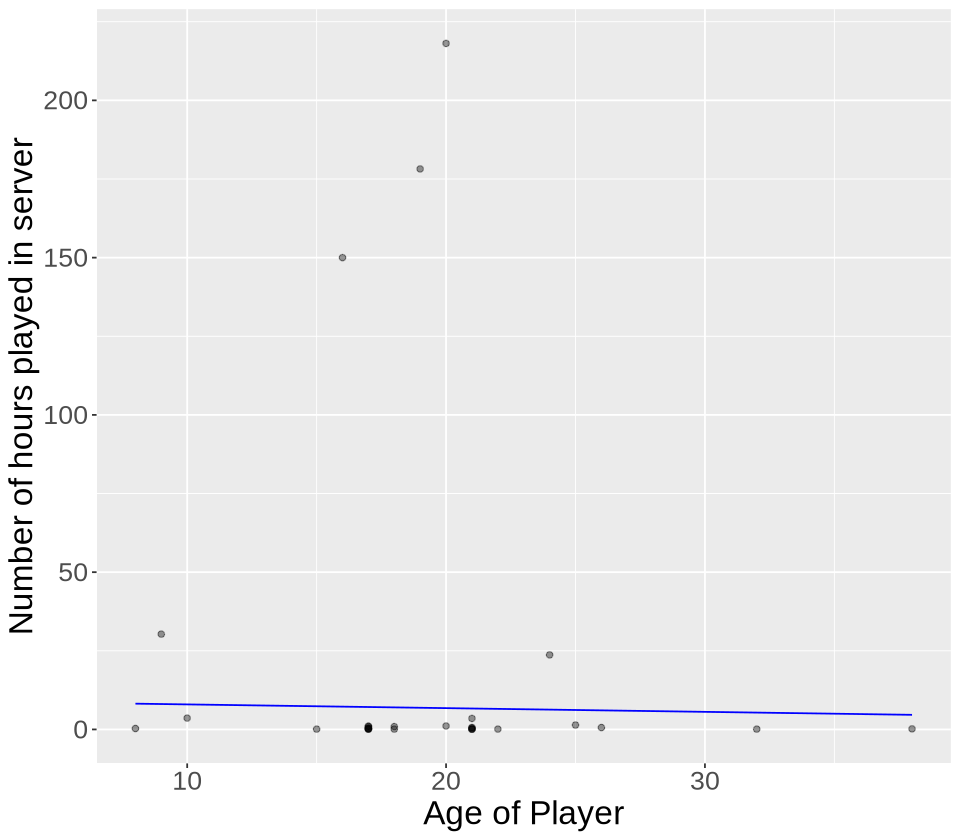

In [11]:
set.seed(411)
players_age_data <- players_data |> 
    select(played_hours, age) |>
    filter(played_hours != 0)

head(players_age_data)

players_plot_age <- players_age_data |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.4) +
    labs(x = "Age of Player", y = "Total Hours Played") +
     theme(text = element_text(size = 17))

players_plot_age

players_split <- initial_split(players_age_data, prop = 0.75, strata = played_hours)
players_train <- training(players_split) 
players_test <- testing(players_split)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

players_recipe <- recipe(played_hours ~ age, data = players_train)

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(lm_spec) |>
    fit(data = players_train)

players_fit

players_pred <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test)

players_test_results <- players_pred |>
    metrics(truth = played_hours, estimate = .pred)
players_test_results

lm_predictions <- players_pred |>
     ggplot(aes(x = age, y = played_hours)) +
        geom_point(alpha = 0.4) +
         geom_line(data = players_pred,
             mapping = aes(x = age, y = .pred), 
            color = "blue") +
         xlab("Age of Player") +
         ylab("Number of hours played in server") +
         theme(text = element_text(size = 20))

lm_predictions

The linear fit has an intercept of 12.5466 and a slope of -0.2556. The root mean square error is 7.959, which is to say that the error is large since it is greater than a large proportion of our data points on the y-axis. A large error suggests that the linear fit is not very good. But regardless of how good the fit is, the slope of -0.1183 suggests there is a very weak negative correlation between age and hours played.

Players dataset was downloaded and loaded into R and then selected for the specific columns experience and played_hours. 


In [12]:
players_experience_data <- select(players_data, experience, played_hours)

experience_data <- players_experience_data |>
   mutate(experience_rank = case_when(
       experience == "Veteran" ~ 5,
       experience == "Pro" ~ 4,
       experience == "Regular" ~ 3,
       experience == "Amateur" ~ 2,
       experience == "Beginner" ~ 1,
       TRUE ~ NA_real_)) |>
   select(experience_rank, everything())
head(experience_data)

experience_rank,experience,played_hours
<dbl>,<chr>,<dbl>
4,Pro,30.3
5,Veteran,3.8
5,Veteran,0.0
2,Amateur,0.7
3,Regular,0.1
2,Amateur,0.0


The experience column was converted to numerical scaling by ranking them from 1 to 5, assigning 5 for "Veteran" and lower values down to 1 for "Beginner". The dataset was then split into training (75%) and testing (25%) subsets with strata = played_hours to ensure the proportion was similar across both splits.

In [13]:
set.seed(411)
players_split <- initial_split(experience_data, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

set.seed(411)
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

players_recipe <- recipe(played_hours ~ experience_rank, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_gridvals <- tibble(neighbors = seq(1, , by = 2))

players_results <- players_workflow |>
   tune_grid(resamples = players_vfold, grid = players_gridvals) |>
   collect_metrics() |>
   filter(.metric == "rmse")

players_min <- players_results |>
    filter(mean == min(mean))
players_min

k_min <- players_min |>
   pull(neighbors)

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,26.83821,5,9.54339,Preprocessor1_Model1


KNN regression model was created using recipe(), KNN model spec, v-fold cross validation on the training set for a grid of values for K, workflow combining recipe and KNN model, and filtering to find the best setting for number of neighbors with the minimum RMSE.

In [14]:
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min)|>
  set_engine("kknn") |>
  set_mode("regression")

players_best_fit <- workflow() |>
   add_recipe(players_recipe) |>
   add_model(players_best_spec) |>
   fit(data = players_training)

players_rmse <- players_best_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == "rmse")
options(repr.plot.width = 10, repr.plot.height = 8)

players_preds <- players_best_fit |>
   predict(players_training) |>
   bind_cols(players_training)

players_preds

.pred,experience_rank,experience,played_hours
<dbl>,<dbl>,<chr>,<dbl>
0.0,5,Veteran,0.0
0.1,3,Regular,0.1
0.1,2,Amateur,0.0
0.1,2,Amateur,0.1
0.0,5,Veteran,0.0
⋮,⋮,⋮,⋮
0.0,5,Veteran,2.7
0.1,2,Amateur,2.1
0.1,2,Amateur,0.8


After, the KNN model was retrained and fit using a new workflow.

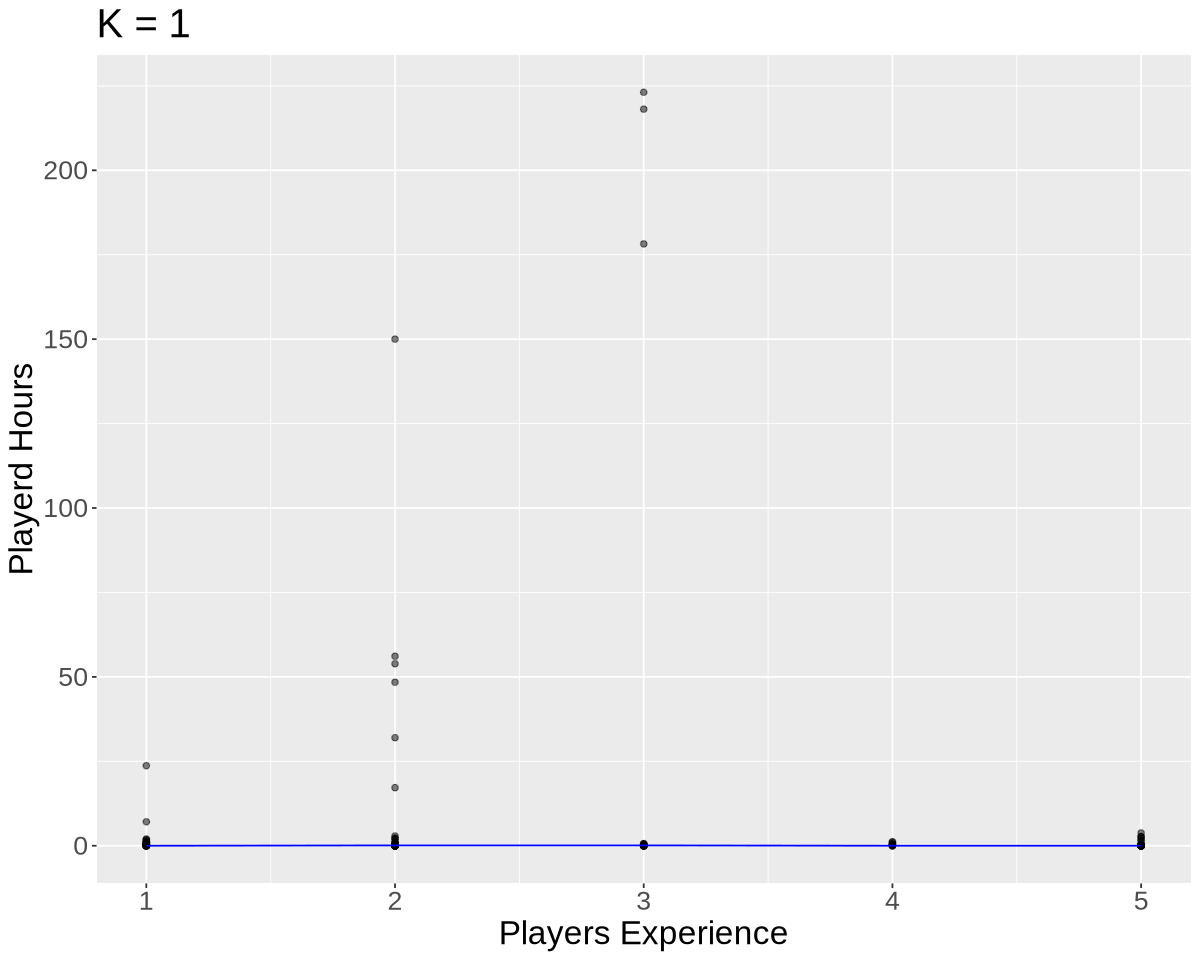

In [15]:
players_plot <- players_preds |>
  ggplot(aes(x = experience_rank, y = played_hours)) +
  geom_point(alpha = 0.5) +
  geom_line(data = players_preds, mapping = aes(x = experience_rank, y = .pred),
            color = "blue") +
  labs(x = "Players Experience",
       y = "Playerd Hours") +
   ggtitle(paste0("K = ", players_min)) +
  theme(text = element_text(size = 20))
 players_plot

RMSE = 5.461282

Predictions were made for the testing set and calculated the RMSE using metrics() and used the prediction results for training to plot a scatter plot relationship between experience_rank and played_hours.


The KNN regression analysis showed a weak relationship between player experience and hours played as the predictions had very little variation across the experience levels. Many of the data points were concentrated near zero or close to zero played hours across all experience levels which resulted in the predicted values (blue line) remaining relatively flat on the scatterplot. This suggests that player experience is not a strong predictor of played hours due to its weak correlation despite having higher played hours in the dataset. This was expected given that the dataset originally showed many players with little to no hours played across all experiences. Presumably, other factors besides experience alone would be more significant in determining hours played. Therefore, these findings indicate that experience level is not a useful metric for predicting player engagement. Game developers would need to consider additional variables to predict user behaviour effectively as focusing just on experience will lead to inconclusive results/false assumptions about player activity. It leads to future questions about whether other variables would be able to predict played hours better or if larger datasets with longer hours played could improve the model's performance using experience level. How would removing zero-hours played affect the model's accuracy as well.

In [16]:
set.seed(411) 

player_split <- initial_split(experience_data, prop = 0.75)
player_training <- training(player_split)
player_testing <- testing(player_split)

head(player_training, n = 10)

experience_rank,experience,played_hours
<dbl>,<chr>,<dbl>
2,Amateur,0.0
5,Veteran,0.0
5,Veteran,0.0
3,Regular,0.0
2,Amateur,0.2
2,Amateur,0.1
2,Amateur,0.0
5,Veteran,12.5
2,Amateur,0.1


Downloaded player data and selected for experience, name and played_hours. Mutated data to set experience to a numerical scale from 1-5 (Beginner to Veteran, respectively) for linear regression. Then split the data into testing and training sets at a 75/25 split.


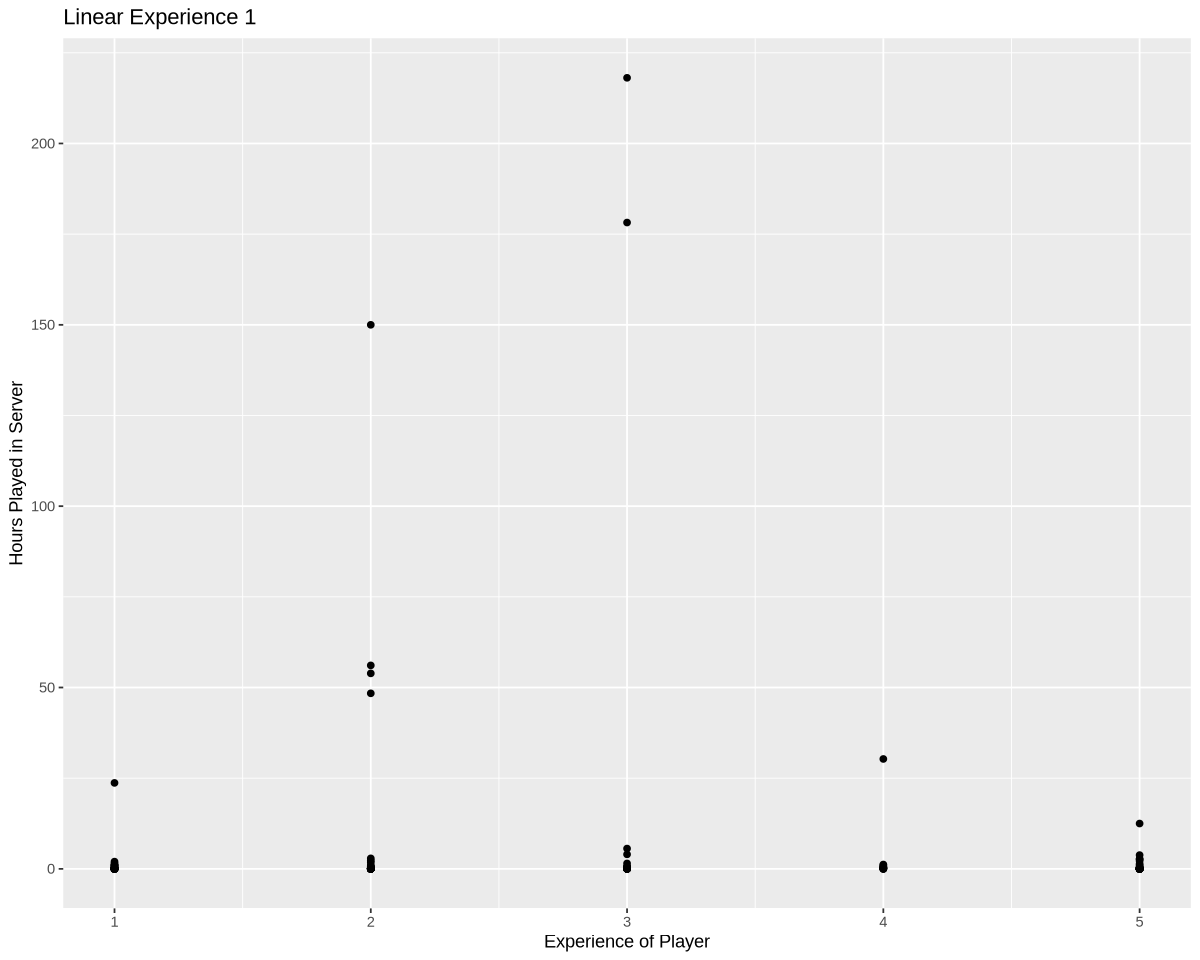

In [19]:
plotting <- ggplot(player_training, aes(x = experience_rank, y = played_hours)) +
    geom_point() +
    labs(x = "Experience of Player", y = "Hours Played in Server", title = "Linear Experience 1")

plotting 

Did an initial plot of the training data to get an idea on how the data looks.

In [21]:
set.seed(411)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(played_hours ~ experience_rank, data = player_training)

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = player_training)

lm_fit

set.seed(411)

training_preds <- lm_fit |>
    predict(player_training) |>
    bind_cols(player_training)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
    (Intercept)  experience_rank  
         7.7011          -0.7134  


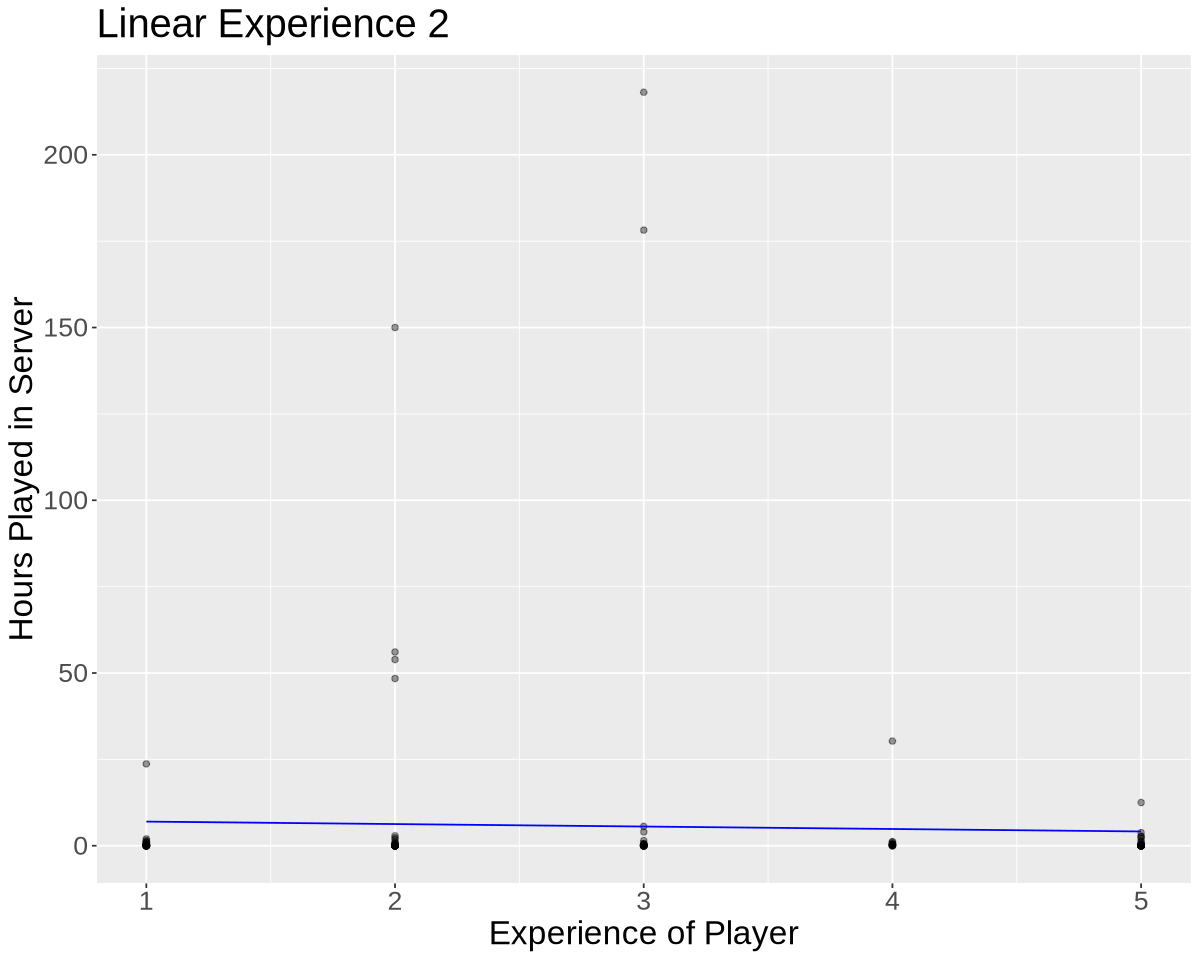

In [23]:
lm_predictions2 <- training_preds |>
    ggplot(aes(x = experience_rank, y = played_hours)) +
        geom_point(alpha = 0.4) +
        geom_line(
            mapping = aes(x = experience_rank, y = .pred), 
            color = "blue") +
        xlab("Experience of Player") +
        ylab("Hours Played in Server") +
    labs(title = "Linear Experience 2") +
        theme(text = element_text(size = 20))
lm_predictions2

Made a linear regression model with the training data by creating a recipe, a model/spec, and workflow. Collected prediction results and used it to plot predictions of training data. 

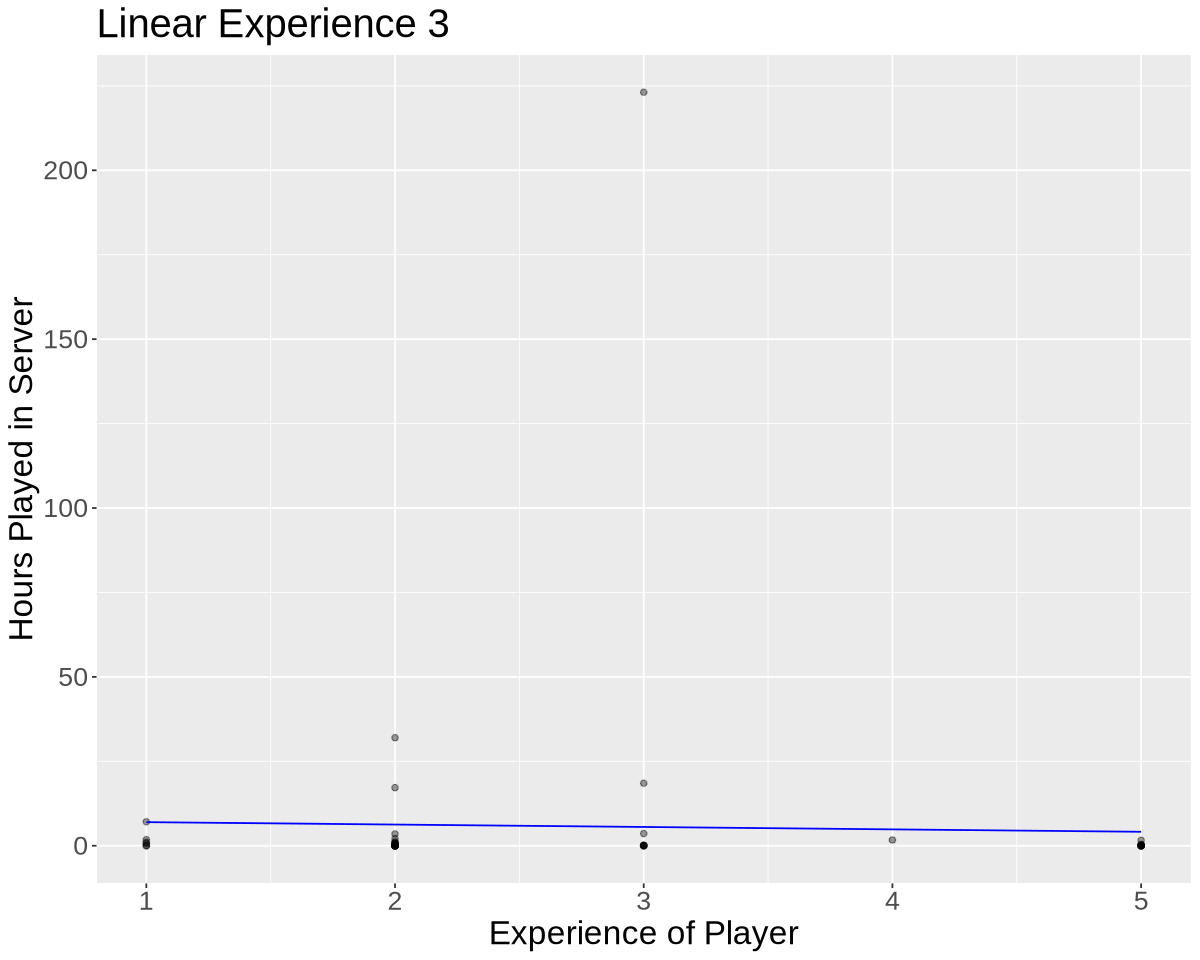

In [24]:
set.seed(411)

testing_pred <- lm_fit |>
    predict(player_testing) |>
    bind_cols(player_testing)

experience_results <- testing_pred |>
    metrics(truth = played_hours, estimate = .pred)


testing_predictions <- testing_pred |>
     ggplot(aes(x = experience_rank, y = played_hours)) +
        geom_point(alpha = 0.4) +
         geom_line(data = testing_pred,
             mapping = aes(x = experience_rank, y = .pred), 
            color = "blue") +
         xlab("Experience of Player") +
         ylab("Hours Played in Server") +
    labs(title = "Linear Experience 3") +
         theme(text = element_text(size = 20))

testing_predictions

Then predicted results with testing data and plotted it as well.

In [25]:
testing_results <- lm_fit |>
    predict(player_testing) |>
    bind_cols(player_testing) |>
    metrics(truth = played_hours, estimate = .pred) 

testing_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.178883e+01
rsq,standard,1.437197e-06
mae,standard,1.010228e+01


Results are inconclusive. The data is not linear enough for the model, and most of the points are at zero or near zero. There is a slight downward trend, where newer players play more, according to the predictions however it is not very accurate to the true values of the data (high RMSE). 

The model is inconclusive with its predictions. This was pretty expected since the data had very little linear relation and many players had less than 1 played hour. There’s not a lot of impact that these findings can have because they  lead to inconclusive results that don’t help with answering what kind of player contributes the most data. 

It could lead to questions about if more data would lead to better results, or if player engagement is predictable with the variables we used.

Discussion:


Experience as a predictor: 

	Between all of our tested variables there seems to be a very slight negative correlation. Whereas a player’s experience level and age increase, their hours played decreases. However, our data suggests all findings are inconclusive, the predictors are pretty weak. Experience had a slight negative correlation which can be visibly observed on the linear regression data graph, but there also seems to be many outliers. The experience data points were unequally distributed, with a larger concentration near and at zero which resulted in the predicted values which formed out blue lines to remain relatively flat. This creates the issue of interpreting the data in the Knn regression graph, since the original data points are relatively flat, it is difficult to determine how well our predicted line fits the actual data. As under normal circumstances, overfitting/underfitting can be determined by how steep/flat the predicted line is. From the given dataset, player experience is not a strong predictor of hours played. Other variables besides just experience alone are needed to create a stronger predictor. The results are expected since we observed that there were many 0 values to begin with. Therefore, to determine whether the correlation truly exists, the dataset must be expanded and then retested in the future. 

Age as a predictor:

	Similarly, age had an even weaker slight negative correlation which is barely noticeable on the linear regression graph. 
